In [222]:
import numpy as np
import pandas as pd
import nilearn
import nibabel
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
import os,sys,glob
from scipy.spatial.distance import cdist, pdist, squareform
import brainplotlib as bpl
from scipy.stats import zscore
import searchlights
import utils
from run_iscs_meg import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
df_meg = pd.read_csv("results/MEG_isc_results.csv", index_col=0)
df_fmri = pd.read_csv("results/fMRI_isc_results.csv", index_col=0)


In [168]:
df_fmri.segment.unique()


array(['all_segs', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15'], dtype=object)

In [173]:
dfm = df_meg[(df_meg['abs'] == True) & (df_meg['MVPA']==False)].groupby(['region','run','segment']).mean().reset_index()
dff = df_fmri[(df_fmri['MVPA']==False) & (df_fmri['segment']!='all_segs')].groupby(['region','run','segment']).mean().reset_index()
dff['segment'] = dff[["segment"]].apply(pd.to_numeric)
# find the regions with highest ISC



In [175]:
sorted_regions = []
for run in dfm.run.unique():
    for seg in dfm[dfm['run']==run].segment.unique():
        subdf = dfm[(dfm['run']==run) & (dfm['segment']==seg)]
        subdfsorted = subdf.sort_values(by='isc',ascending=False)
        regs_sorted=subdfsorted['region'].values
        sorted_regions.append(pd.DataFrame({'run':run, 'segment':seg, 'region': regs_sorted,'rank':np.arange(len(regs_sorted))}))
sorted_meg = pd.concat(sorted_regions)

In [176]:
sorted_regions = []
a=0
for run in dff.run.unique():
    for seg in dff[dff['run']==run].segment.unique():
        subdf = dff[(dff['run']==run) & (dff['segment']==seg)]
        subdfsorted = subdf.sort_values(by='isc',ascending=False)
        regs_sorted=subdfsorted['region'].values
        a+=1
        sorted_regions.append(pd.DataFrame({'run':run, 'segment':seg, 'region': regs_sorted, 'rank':np.arange(len(regs_sorted))}))
sorted_fmri = pd.concat(sorted_regions)

In [236]:
# there are 110 unique segments
# take top 20 regions from each run / segment (10%)
fmri_top10, counts_fmri = np.unique(sorted_fmri[sorted_fmri['rank'] < 30]['region'].values,return_counts=True) # 106 top
meg_top10, counts_meg = np.unique(sorted_meg[sorted_meg['rank'] < 30]['region'].values,return_counts=True) # 153 top

# find the regions that occur more than 22 times (top 20%)
fmri_top20 = fmri_top10[counts_fmri>=22]
meg_top20 = meg_top10[counts_meg>=22]

dfa = pd.DataFrame(columns=['type','count','region'])
dfa = pd.concat([dfa, pd.DataFrame({'type':'fmri', 
                                    'count':[counts_fmri[fmri_top10 == r][0] for r in fmri_top20], 
                                   'region':fmri_top20})])
dfa = pd.concat([dfa, pd.DataFrame({'type':'meg', 
                                    'count':[counts_meg[meg_top10 == r][0] for r in meg_top20], 
                                   'region':meg_top20})])

                 

In [237]:
f = dff[dff['region'].isin(overlap3020)]
f['type']='fmri'
f['normed_isc'] = zscore(f['isc'].values)
m = dfm[dfm['region'].isin(overlap3020)]
m['type']='meg'
m['normed_isc'] = zscore(m['isc'].values)
d=pd.concat([m,f])

/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithC

In [238]:
d = d.reset_index()
x=0
overall = np.zeros(d.shape[0])
for r in d['run'].unique():
    da = d[d['run']==r]
    for seg in da.segment.unique():

        db = da[da['segment']==seg]
        overall[db.index.values]=x
        # print(r,seg)
        x+=1
d['overall']=overall

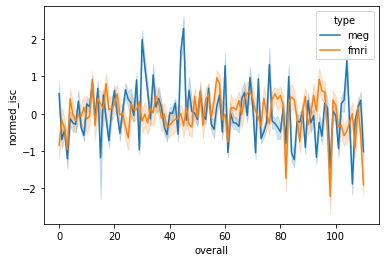

In [227]:
subdf = d[(d['region'].isin(overlap3020))]

sns.lineplot(data=subdf, x='overall', y='normed_isc', hue='type')

In [234]:
subdf[(subdf['overall'] < 60) & (subdf['overall'] > 40)]

,index,region,run,segment,isc,test_sub,abs,MVPA,type,normed_isc,overall
41,41,17networks_LH_Aud_ST_1,3,10,0.008264,6.5,1.0,False,meg,-0.527244,41.0
42,42,17networks_LH_Aud_ST_1,3,11,0.021463,6.5,1.0,False,meg,0.371900,42.0
43,43,17networks_LH_Aud_ST_1,3,12,-0.011718,6.5,1.0,False,meg,-1.888468,43.0
44,44,17networks_LH_Aud_ST_1,3,13,0.018806,6.5,1.0,False,meg,0.190902,44.0
45,45,17networks_LH_Aud_ST_1,4,0,0.018636,6.5,1.0,False,meg,0.179290,45.0
...,...,...,...,...,...,...,...,...,...,...,...
6574,21944,17networks_RH_VisualC_ExStr_1,4,5,0.167164,10.6,NaN,False,fmri,-1.631026,50.0
6575,21945,17networks_RH_VisualC_ExStr_1,4,6,0.577743,10.6,NaN,False,fmri,0.431175,51.0
6576,21946,17networks_RH_VisualC_ExStr_1,4,7,0.502042,10.6,NaN,False,fmri,0.050957,52.0
6577,21947,17networks_RH_VisualC_ExStr_1,4,8,0.505668,10.6,NaN,False,fmri,0.069170,53.0


In [229]:
np.save('regions_to_include.npy', overlap3020)

In [230]:
np.save('vertices_to_include.npy', brain_arr_3020)

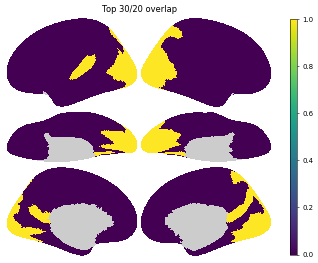

In [241]:
overlap3020 = [i for i in fmri_top20 if i in meg_top20]

brain_arr_3020 = make_brain_array(overlap3020)
img, sc = bpl.brain_plot(brain_arr_3020, vmin=0, vmax=1, return_scale=True) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title("Top 30/20 overlap")
plt.imshow(img)
cbar = plt.colorbar(sc, shrink=0.8, aspect=30)

In [245]:
np.nansum(brain_arr_3010)

6236.0

64


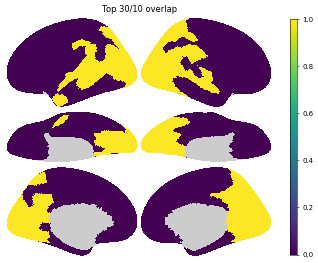

In [122]:
overlap3010 = [i for i in fmri_top20 if i in meg_top20]
print(len(overlap3010))

brain_arr_3010 = make_brain_array(overlap3010)
img, sc = bpl.brain_plot(brain_arr_3010, vmin=0, vmax=1, return_scale=True) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title("Top 30/10 overlap")
plt.imshow(img)
cbar = plt.colorbar(sc, shrink=0.8, aspect=30)

In [118]:
overlap2020 = [i for i in fmri_top20 if i in meg_top20]
len(overlap2020)

17

In [116]:
dfa.region.unique().shape, dfa.shape
overlap3020 = [i for i in fmri_top20 if i in meg_top20]

In [240]:
def make_brain_array(regions):
    on_brain = np.zeros((labels.shape))
    on_brain[:]=np.nan
    for la, name in enumerate(names):
        name = name.decode()
        if name == "Background":
            continue
        mask=np.where(labels == la)[0]
        if name in regions:
            val = 1
        else:
            val = 0
        
        on_brain[mask] = val
    return on_brain

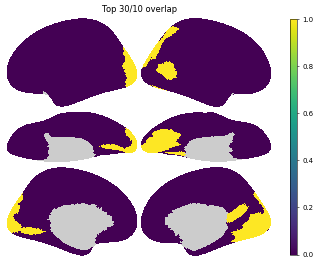

In [115]:
brain_arr_3010 = make_brain_array(overlap3010)
img, sc = bpl.brain_plot(brain_arr_2020, vmin=0, vmax=1, return_scale=True) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title("Top 30/10 overlap")
plt.imshow(img)
cbar = plt.colorbar(sc, shrink=0.8, aspect=30)

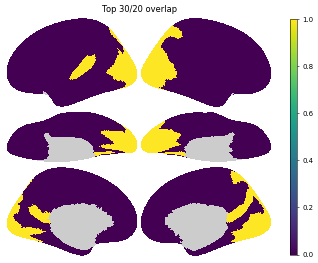

In [100]:
brain_arr_3020 = make_brain_array(overlap3020)
img, sc = bpl.brain_plot(brain_arr_3020, vmin=0, vmax=1, return_scale=True) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title("Top 30/20 overlap")
plt.imshow(img)
cbar = plt.colorbar(sc, shrink=0.8, aspect=30)

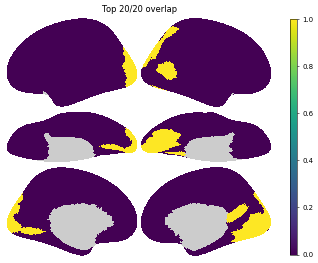

In [119]:
brain_arr_2020 = make_brain_array(overlap2020)
img, sc = bpl.brain_plot(brain_arr_2020, vmin=0, vmax=1, return_scale=True) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title("Top 20/20 overlap")
plt.imshow(img)
cbar = plt.colorbar(sc, shrink=0.8, aspect=30)

In [98]:
brain_arr_3020

array([0., 1., 0., ..., 0., 0., 0.])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]),
 <a list of 55 Text xticklabel objects>)

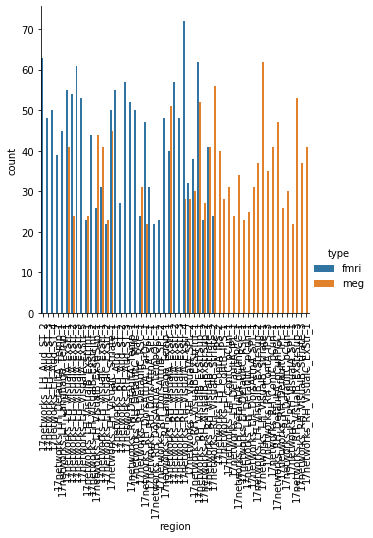

In [84]:
g = sns.catplot(data=dfa, kind='bar', x="region", y='count', hue='type')
plt.xticks(rotation = 90)

In [55]:
fmri_top20p,meg_top10

(array(['17networks_LH_Aud_ST_2', '17networks_LH_Aud_ST_3',
        '17networks_LH_Aud_ST_4', '17networks_LH_DefaultA_Temp_1',
        '17networks_LH_Language_Temp_1', '17networks_LH_VisualA_ExStr_1',
        '17networks_LH_VisualA_ExStr_2', '17networks_LH_VisualA_ExStr_3',
        '17networks_LH_VisualA_ExStr_5', '17networks_LH_VisualC_Striate_1',
        '17networks_RH_Aud_ST_1', '17networks_RH_Aud_ST_3',
        '17networks_RH_DefaultA_Temp_1', '17networks_RH_DefaultC_PHC_1',
        '17networks_RH_DorsAttnA_ParOcc_1',
        '17networks_RH_Language_Temp_1', '17networks_RH_VisualA_ExStr_2',
        '17networks_RH_VisualA_ExStr_3', '17networks_RH_VisualA_ExStr_4',
        '17networks_RH_VisualB_ExStrSup_1',
        '17networks_RH_VisualB_Striate_1'], dtype=object),
 array(['17networks_LH_ContA_IPS_2', '17networks_LH_VisualB_ExStrSup_1',
        '17networks_LH_VisualB_Striate_1', '17networks_LH_VisualC_ExStr_1',
        '17networks_LH_VisualC_Striate_1',
        '17networks_RH_Defaul

In [48]:
sorted_fmri[sorted_fmri['rank'] < 10]['region'].unique().shape

(106,)

In [49]:
sorted_meg[sorted_meg['rank'] < 10]['region'].unique().shape

(153,)

In [19]:
meg = df_meg.groupby(['region','run','abs','MVPA']).mean().reset_index()
meg['type']='meg'
make_plots(meg, 'mean_')

ISC meg, mvpa=True, run=1, segment=7.5, absolute_val=False
ISC meg, mvpa=True, run=1, segment=7.5, absolute_val=True
ISC meg, mvpa=True, run=2, segment=7.0, absolute_val=False
ISC meg, mvpa=True, run=2, segment=7.0, absolute_val=True
ISC meg, mvpa=True, run=3, segment=6.5, absolute_val=False
ISC meg, mvpa=True, run=3, segment=6.5, absolute_val=True
ISC meg, mvpa=True, run=4, segment=7.0, absolute_val=False
ISC meg, mvpa=True, run=4, segment=7.0, absolute_val=True
ISC meg, mvpa=True, run=5, segment=5.5, absolute_val=False
ISC meg, mvpa=True, run=5, segment=5.5, absolute_val=True
ISC meg, mvpa=True, run=6, segment=5.0, absolute_val=False
ISC meg, mvpa=True, run=6, segment=5.0, absolute_val=True
ISC meg, mvpa=True, run=7, segment=7.5, absolute_val=False
ISC meg, mvpa=True, run=7, segment=7.5, absolute_val=True
ISC meg, mvpa=True, run=8, segment=5.5, absolute_val=False
ISC meg, mvpa=True, run=8, segment=5.5, absolute_val=True
ISC meg, mvpa=False, run=1, segment=7.5, absolute_val=True
ISC m

In [21]:
fmri

,region,run,MVPA,Unnamed: 0,isc,test_sub,abs,type
0,17networks_LH_Aud_ST_1,1,False,7.0,0.334650,10.6,NaN,fmri
1,17networks_LH_Aud_ST_1,1,True,7.0,0.237319,10.6,NaN,fmri
2,17networks_LH_Aud_ST_1,2,False,7.0,0.437911,10.6,NaN,fmri
3,17networks_LH_Aud_ST_1,2,True,7.0,0.300151,10.6,NaN,fmri
4,17networks_LH_Aud_ST_1,3,False,7.0,0.341150,10.6,NaN,fmri
...,...,...,...,...,...,...,...,...
3195,17networks_RH_VisualC_ExStr_1,6,True,7.0,0.388879,10.6,NaN,fmri
3196,17networks_RH_VisualC_ExStr_1,7,False,7.0,0.482998,10.6,NaN,fmri
3197,17networks_RH_VisualC_ExStr_1,7,True,7.0,0.400098,10.6,NaN,fmri
3198,17networks_RH_VisualC_ExStr_1,8,False,7.0,0.351813,10.6,NaN,fmri


In [24]:
fmri = df_fmri.groupby(['region','run','MVPA']).max().reset_index()
fmri['type']='fmri'
fmri['segment']='seg'
fmri['abs'] = False

make_plots(fmri, 'max_')

ISC fmri, mvpa=True, run=1, segment=seg, absolute_val=False
ISC fmri, mvpa=True, run=2, segment=seg, absolute_val=False
ISC fmri, mvpa=True, run=3, segment=seg, absolute_val=False
ISC fmri, mvpa=True, run=4, segment=seg, absolute_val=False
ISC fmri, mvpa=True, run=5, segment=seg, absolute_val=False
ISC fmri, mvpa=True, run=6, segment=seg, absolute_val=False
ISC fmri, mvpa=True, run=7, segment=seg, absolute_val=False
ISC fmri, mvpa=True, run=8, segment=seg, absolute_val=False
ISC fmri, mvpa=False, run=1, segment=seg, absolute_val=False
ISC fmri, mvpa=False, run=2, segment=seg, absolute_val=False
ISC fmri, mvpa=False, run=3, segment=seg, absolute_val=False
ISC fmri, mvpa=False, run=4, segment=seg, absolute_val=False
ISC fmri, mvpa=False, run=5, segment=seg, absolute_val=False
ISC fmri, mvpa=False, run=6, segment=seg, absolute_val=False
ISC fmri, mvpa=False, run=7, segment=seg, absolute_val=False
ISC fmri, mvpa=False, run=8, segment=seg, absolute_val=False


In [98]:
df = pd.read_csv("results/fMRI_isc_results.csv")
df.groupby(['MVPA']).max()

,Unnamed: 0,region,run,segment,isc,type,test_sub,abs
MVPA,,,,,,,,
False,14,17networks_RH_VisualC_ExStr_1,8,all_segs,1.000000,MRI,20,NaN
True,14,17networks_RH_VisualC_ExStr_1,8,all_segs,0.927253,MRI,20,NaN


In [5]:
outstr = '/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg'


a = np.load(f'{outstr}/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-10_region-17networks_LH_DefaultB_PFCl_1.npy')

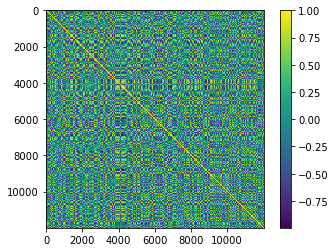

In [12]:
plt.imshow(1-squareform(pdist(a, 'correlation')))
plt.colorbar()

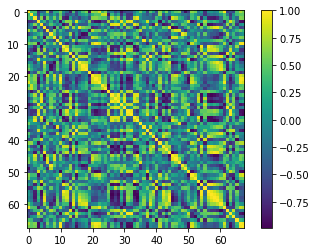

In [15]:
plt.imshow(1-squareform(pdist(a.T, 'correlation')))
plt.colorbar()

In [2]:
labels = np.load('Schaefer2018_200Parcels_Kong2022_17Networks_order_labels.npy')
names = np.load('Schaefer2018_200Parcels_Kong2022_17Networks_order_names.npy')
outstr = '/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg'

In [3]:
def run_isc(data):
    results = []
    n_subjects = len(data)
    for test_sub in range(n_subjects):
        train_subjects = np.setdiff1d(np.arange(n_subjects),test_sub)
        train_data = np.squeeze(np.mean(data[train_subjects,:,:],axis=0))
        test_data = np.squeeze(data[test_sub,:,:])
        r=np.corrcoef(train_data.ravel(), test_data.ravel())[0,1]
        results.append(r)
    return results

In [5]:
data = utils.load_all_subjects(1, imtype='fmri', hemi=None, part=None, z=True)

/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [43]:
x=np.mean(data,axis=2)
x=x[:,:,np.newaxis]
x.shape

(15, 450, 1)

In [56]:
labels.max()

200

In [57]:
names.shape

(202,)

In [59]:
for la, name in enumerate(names):
    mask=np.where(labels == la)[0]
    print(len(mask),name)

870 b'Background'
126 b'17networks_LH_DefaultA_IPL_1'
83 b'17networks_LH_DefaultA_PFCm_1'
127 b'17networks_LH_DefaultA_Temp_1'
122 b'17networks_LH_DefaultA_Temp_2'
60 b'17networks_LH_DefaultA_TempPole_1'
74 b'17networks_LH_DefaultA_TempPole_2'
115 b'17networks_LH_DefaultA_pCunPCC_1'
119 b'17networks_LH_DefaultB_FPole_1'
65 b'17networks_LH_DefaultB_IPL_1'
84 b'17networks_LH_DefaultB_IPL_2'
82 b'17networks_LH_DefaultB_PFCd_1'
90 b'17networks_LH_DefaultB_PFCd_2'
108 b'17networks_LH_DefaultB_PFCd_3'
68 b'17networks_LH_DefaultB_PFCl_1'
93 b'17networks_LH_DefaultB_PFCv_1'
95 b'17networks_LH_DefaultB_TempPole_1'
69 b'17networks_LH_DefaultC_IPL_1'
135 b'17networks_LH_DefaultC_PFCd_1'
130 b'17networks_LH_DefaultC_PHC_1'
113 b'17networks_LH_DefaultC_RSC_1'
85 b'17networks_LH_DefaultC_pCun_1'
70 b'17networks_LH_Language_IFG_1'
59 b'17networks_LH_Language_IFG_2'
79 b'17networks_LH_Language_PFCl_1'
118 b'17networks_LH_Language_Temp_1'
45 b'17networks_LH_ContA_Cingm_1'
72 b'17networks_LH_ContA_IPS_1

In [89]:
def make_plots(results_data):
    datatype=results_data['type'].values[0]
    # loop through runs
    for mvpa in [True, False]:
        for run in results_data['run'].unique():
            subset_df = results_data[(results_data['MVPA']==mvpa) & (results_data['run']==run)]
            # make for all values of segment
            for seg in subset_df['segment'].unique():
                subdf=subset_df[subset_df['segment']==seg]
                # make for all values of abs
                for ab in subdf['abs'].unique():
                    res = subdf[subdf['abs']==ab]
                    array = make_brain_array(res)
                    title = f"ISC {datatype}, mvpa={mvpa}, run={run}, segment={seg}, absolute_val={ab}"
                    img, sc = bpl.brain_plot(array, vmin=0, vmax=1, return_scale=True) 
                    fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
                    plt.axis('off')
                    plt.title(title)
                    plt.imshow(img)
                    cbar = plt.colorbar(sc, shrink=0.8, aspect=30)
                    plt.savefig(f'plots/{datatype}_mvpa-{mvpa}_run-{run}_segment-{seg}_ab-{ab}.png', bbox_inches='tight')
                    print(title)
            

MRI
[0.07592783 0.33158805 0.06273169 ... 0.07995077 0.07995077 0.07995077]
ISC MRI, mvpa=True, run=1, segment=all_segs, absolute_val=False


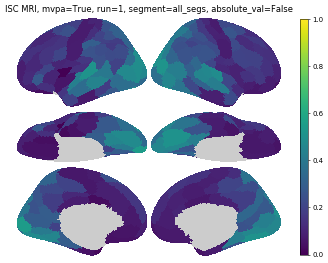

In [90]:
df = pd.read_csv('results/fMRI_isc_results.csv')
df['abs'] = False
arr   = make_plots(df)


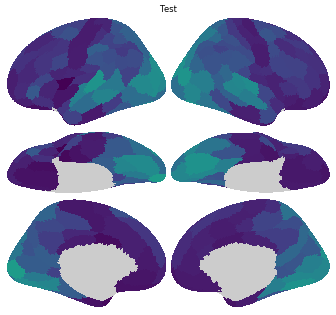

In [87]:
#title = f"ISC {datatype}, mvpa={mvpa}, run={run}, segment={seg}, absolute_val={ab}"
title="Test"
img, sc = bpl.brain_plot(arr, vmin=0, vmax=1, return_scale=True) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title(title)
plt.imshow(img)

In [51]:
x = df1['segment'].unique()[0]
subdf=df1[df1['segment']==x]

In [52]:
subdf

,Unnamed: 0,region,run,segment,isc,type,test_sub,abs,MVPA
0,0,17networks_LH_DefaultA_IPL_1,1,all_segs,0.266441,MRI,1,NaN,True
1,1,17networks_LH_DefaultA_IPL_1,1,all_segs,0.050141,MRI,2,NaN,True
2,2,17networks_LH_DefaultA_IPL_1,1,all_segs,0.162748,MRI,3,NaN,True
3,3,17networks_LH_DefaultA_IPL_1,1,all_segs,0.315060,MRI,4,NaN,True
4,4,17networks_LH_DefaultA_IPL_1,1,all_segs,0.252461,MRI,5,NaN,True
...,...,...,...,...,...,...,...,...,...
95530,10,17networks_RH_VisualC_ExStr_1,1,all_segs,0.397640,MRI,16,NaN,True
95531,11,17networks_RH_VisualC_ExStr_1,1,all_segs,0.445240,MRI,17,NaN,True
95532,12,17networks_RH_VisualC_ExStr_1,1,all_segs,0.383794,MRI,18,NaN,True
95533,13,17networks_RH_VisualC_ExStr_1,1,all_segs,0.385150,MRI,19,NaN,True


In [6]:
def run_job(run):
    results = []
    data = np.nan_to_num(utils.load_all_subjects(run, imtype='fmri', hemi=None, part=None, z=True))
    for la, name in enumerate(names):
        name=name.decode()
        if name == "Background":
            continue
        mask=np.where(labels == la)[0]
        d=np.nan_to_num(data[:, :, mask])
        # run ISC for this run 
        ISCs = run_isc(d)
        temp=pd.DataFrame({"region":name, 'run':run, 'segment':"all_segs", 
                           'isc':ISCs, 'type':'MRI', 
                           'test_sub':utils.MRI_subjects, 'abs':"NA", "MVPA":"true"})
        results.append(temp)
        
        # run over average
        d1 = np.mean(d,axis=2)
        d1 = d1[:,:,np.newaxis]
        ISCs = run_isc(d1) # run over avg
        temp=pd.DataFrame({"region":name, 'run':run, 'segment':"all_segs", 
                           'isc':ISCs, 'type':'MRI', 
                           'test_sub':utils.MRI_subjects, 'abs':"NA", "MVPA":"false"})
        results.append(temp)
        
        # get 60s segments (30TRs) to correspond with MEG
        for i, t0 in enumerate(np.arange(0, d.shape[1], 60 * 0.5)): # loop yhrough all 1-min segments
            t1 = t0 + 60*0.5
            subdat = d[:, np.arange(int(t0), int(t1)), :]

            ISCs = run_isc(np.nan_to_num(subdat))
            temp=pd.DataFrame({"region":name, 'run':run, 'segment':i, 
                           'isc':ISCs, 'type':'MRI', 
                           'test_sub':utils.MRI_subjects, 'abs':"NA", "MVPA":"true"})
            results.append(temp)
            
            ISCs = run_isc(np.nan_to_num(d1[:,np.arange(int(t0), int(t1)), :]))
            temp=pd.DataFrame({"region":name, 'run':run, 'segment':i, 
                           'isc':ISCs, 'type':'MRI', 
                           'test_sub':utils.MRI_subjects, 'abs':"NA", "MVPA":"False"})
            results.append(temp)
    return pd.concat(results)
            
        
a = run_job(1)

In [62]:
a[a['segment']=='all_segs'].groupby(['region','MVPA']).mean()

run       isc  test_sub
region                          MVPA                          
17networks_LH_Aud_ST_1          false  1.0  0.360840      10.6
                                true   1.0  0.248551      10.6
17networks_LH_Aud_ST_2          false  1.0  0.706740      10.6
                                true   1.0  0.514430      10.6
17networks_LH_Aud_ST_3          false  1.0  0.620435      10.6
...                                    ...       ...       ...
17networks_RH_VisualB_Striate_2 true   1.0  0.429761      10.6
17networks_RH_VisualB_Striate_3 false  1.0  0.373826      10.6
                                true   1.0  0.262836      10.6
17networks_RH_VisualC_ExStr_1   false  1.0  0.422877      10.6
                                true   1.0  0.364408      10.6

[400 rows x 3 columns]

In [78]:
labels.shape

(20484,)

In [69]:
on_brain = np.zeros((10242*2))

for la, name in enumerate(names):
    name=name.decode()
    if name == "Background":
        continue
    mask=np.where(labels == la)[0]
    res = a[(a['segment'] == 'all_segs') & (a['MVPA']=='true') & (a['region']==name)]['isc'].mean()
    on_brain[mask] = res

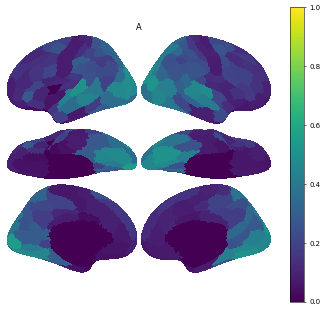

In [77]:
img,sc = bpl.brain_plot(on_brain, vmin=0, vmax=1, return_scale=True) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title('A')
cbar = plt.colorbar(sc)
plt.imshow(img)

[0.07592783 0.33158805 0.06273169 ... 0.07995077 0.07995077 0.07995077]
ISC MRI, mvpa=true, run=1, segment=all_segs, absolute_val=NA
[ 0.04832349  0.03184609 -0.03244    ...  0.06140983  0.06140983
  0.06140983]
ISC MRI, mvpa=true, run=1, segment=0, absolute_val=NA
[0.18013274 0.28573432 0.06816146 ... 0.03936451 0.03936451 0.03936451]
ISC MRI, mvpa=true, run=1, segment=1, absolute_val=NA
[0.03781032 0.21917344 0.08713518 ... 0.06810251 0.06810251 0.06810251]
ISC MRI, mvpa=true, run=1, segment=2, absolute_val=NA
[0.03729125 0.11452844 0.0330108  ... 0.04578223 0.04578223 0.04578223]
ISC MRI, mvpa=true, run=1, segment=3, absolute_val=NA
[0.08931625 0.32011787 0.03400477 ... 0.06953232 0.06953232 0.06953232]
ISC MRI, mvpa=true, run=1, segment=4, absolute_val=NA
[0.11911033 0.37518703 0.03928564 ... 0.05146036 0.05146036 0.05146036]
ISC MRI, mvpa=true, run=1, segment=5, absolute_val=NA
[ 0.10435894  0.38087476 -0.026385   ...  0.15809988  0.15809988
  0.15809988]
ISC MRI, mvpa=true, run=1

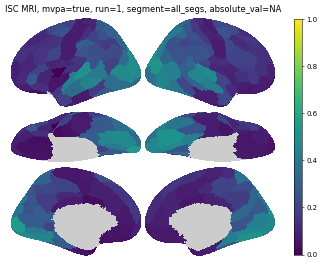

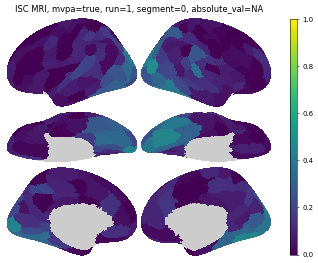

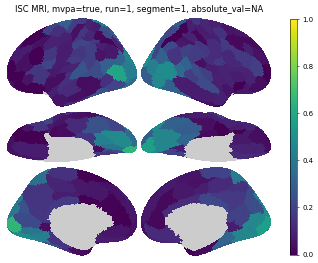

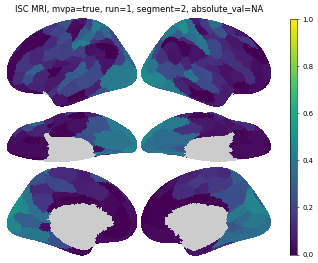

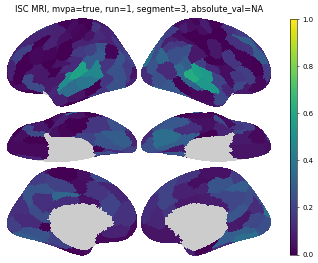

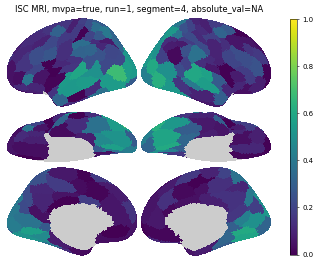

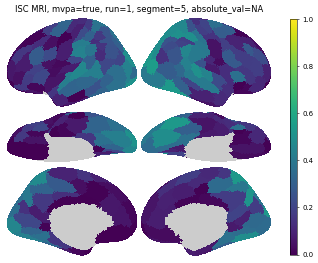

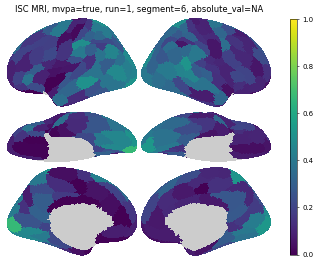

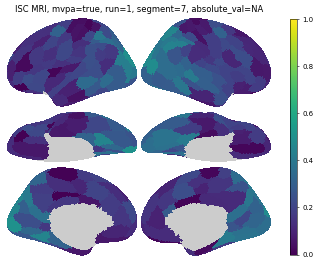

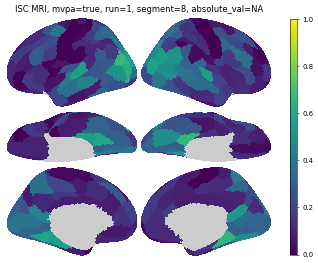

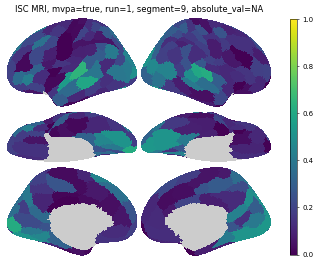

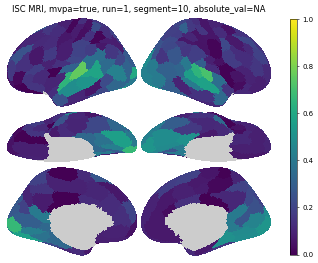

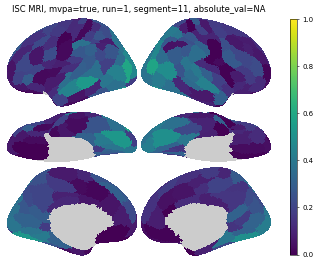

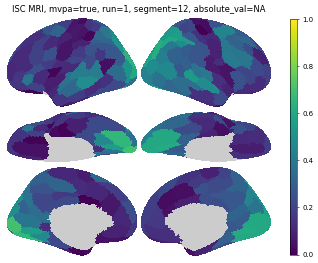

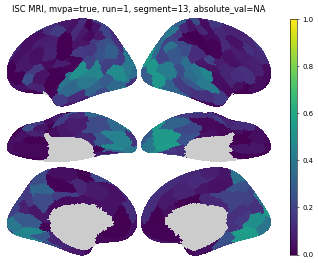

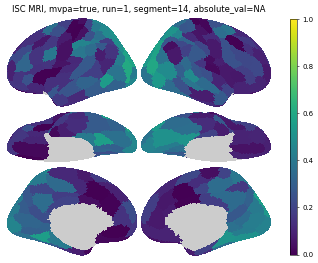

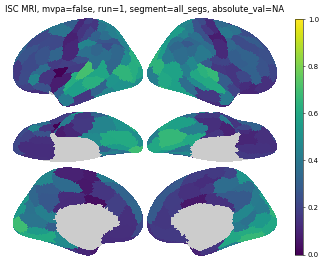

In [24]:
def make_brain_array(subset_df):
    on_brain = np.zeros((labels.shape))
    on_brain[:]=np.nan
    for la, name in enumerate(names):
        name=name.decode()
        if name == "Background":
            continue
        mask=np.where(labels == la)[0]
        res = np.nanmean(subset_df[(subset_df['region']==name)]['isc'].values)
        on_brain[mask] = res
    return on_brain
        

def make_plots(results_data):
    datatype=results_data['type'].values[0]
    # loop through runs
    for mvpa in ['true','false']:
        for run in results_data['run'].unique():
            subset_df = results_data[(results_data['MVPA']==mvpa) & (results_data['run']==run)]
            # make for all values of segment
            for seg in subset_df['segment'].unique():
                subdf=subset_df[subset_df['segment']==seg]
                # make for all values of abs
                for ab in subdf['abs'].unique():
                    res = subdf[subdf['abs']==ab]
                    # return res
                    array = make_brain_array(res)
                    print(array)
                    title = f"ISC {datatype}, mvpa={mvpa}, run={run}, segment={seg}, absolute_val={ab}"
                    img,sc = bpl.brain_plot(array, vmin=0, vmax=1, return_scale=True) 
                    fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(title)
                    cbar = plt.colorbar(sc, shrink=0.8, aspect=30)
                    plt.savefig(f'plots/{datatype}_mvpa-{mvpa}_run-{run}_segment-{seg}_ab-{ab}.png', bbox_inches='tight')
                    print(title)
                    
r = make_plots(a)

In [17]:
on_brain = np.zeros((labels.shape))
on_brain[:]=np.nan
for la, name in enumerate(names):
    if name == "Background":
        continue
    mask=np.where(labels == la)[0]
    res = np.nanmean(r[(r['region']==name)]['isc'].values)
    on_brain[mask] = res
# brain = make_brain_array(r)

/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [22]:
print(name)
r[(r['region']==name)]#['isc'].values

b'17networks_RH_VisualC_ExStr_1'


,region,run,segment,isc,type,test_sub,abs,MVPA


In [48]:
for la, name in enumerate(names):
    name = name.decode()
    print(name)
    if name == 'Background':
        print("cont")
        continue

Background
cont
17networks_LH_DefaultA_IPL_1
17networks_LH_DefaultA_PFCm_1
17networks_LH_DefaultA_Temp_1
17networks_LH_DefaultA_Temp_2
17networks_LH_DefaultA_TempPole_1
17networks_LH_DefaultA_TempPole_2
17networks_LH_DefaultA_pCunPCC_1
17networks_LH_DefaultB_FPole_1
17networks_LH_DefaultB_IPL_1
17networks_LH_DefaultB_IPL_2
17networks_LH_DefaultB_PFCd_1
17networks_LH_DefaultB_PFCd_2
17networks_LH_DefaultB_PFCd_3
17networks_LH_DefaultB_PFCl_1
17networks_LH_DefaultB_PFCv_1
17networks_LH_DefaultB_TempPole_1
17networks_LH_DefaultC_IPL_1
17networks_LH_DefaultC_PFCd_1
17networks_LH_DefaultC_PHC_1
17networks_LH_DefaultC_RSC_1
17networks_LH_DefaultC_pCun_1
17networks_LH_Language_IFG_1
17networks_LH_Language_IFG_2
17networks_LH_Language_PFCl_1
17networks_LH_Language_Temp_1
17networks_LH_ContA_Cingm_1
17networks_LH_ContA_IPS_1
17networks_LH_ContA_IPS_2
17networks_LH_ContA_PFCl_1
17networks_LH_ContA_PFCl_2
17networks_LH_ContA_Temp_1
17networks_LH_ContB_IPL_1
17networks_LH_ContB_IPS_1
17networks_LH

In [35]:
data = utils.load_all_subjects(1, imtype='fmri', hemi=None, part=None, z=True)
for la, name in enumerate(names):
    name = name.decode()
    if name == 'Background':
        continue
    mask = np.where(labels == la)[0]
    d=np.nan_to_num(data[:, :, mask])
    
    # get 60s segments (30TRs) to correspond with MEG
    for i, t0 in enumerate(np.arange(0, d.shape[1], 60 * 0.5)): # loop yhrough all 1-min segments
        t1 = t0 + 60*0.5
        subdat = d[:, np.arange(int(t0), int(t1)), :]
        
        isc=run_isc(np.nan_to_num(subdat))
        print(np.mean(isc), name, run, i)

0.03211884005940843 17networks_LH_DefaultA_IPL_1 8 0
0.06675506395155857 17networks_LH_DefaultA_IPL_1 8 1
-0.1111396170308067 17networks_LH_DefaultA_IPL_1 8 2
0.015105139990968637 17networks_LH_DefaultA_IPL_1 8 3
0.21349826121483406 17networks_LH_DefaultA_IPL_1 8 4
0.25730204646592225 17networks_LH_DefaultA_IPL_1 8 5
0.4524350254390239 17networks_LH_DefaultA_IPL_1 8 6
0.16524452786251226 17networks_LH_DefaultA_IPL_1 8 7
0.18610176365441583 17networks_LH_DefaultA_IPL_1 8 8
0.4139120595103282 17networks_LH_DefaultA_IPL_1 8 9
0.16126712483926456 17networks_LH_DefaultA_IPL_1 8 10
0.2694215047926358 17networks_LH_DefaultA_IPL_1 8 11
0.2708399603517137 17networks_LH_DefaultA_IPL_1 8 12
0.30178964478648085 17networks_LH_DefaultA_IPL_1 8 13
0.14903619371713991 17networks_LH_DefaultA_IPL_1 8 14
0.1335661279068338 17networks_LH_DefaultA_PFCm_1 8 0
0.062149350888412454 17networks_LH_DefaultA_PFCm_1 8 1
-0.0293906011006386 17networks_LH_DefaultA_PFCm_1 8 2
0.09542723363309961 17networks_LH_Default

KeyboardInterrupt: 

In [ ]:
def run_jobs(run):
    

In [ ]:
iscs = pd.DataFrame(columns=['region','test_sub','run','segment','isc','type'])

for name in names:
    name = name.decode()
    if name == 'Background':
        continue
    for run in range(1,utils.n_runs+1):
        sub=3
        NSEGS = len(glob.glob(f'{outstr}/meg_sub-{sub:02d}*run-{run:02d}_*_region-{name}.npy'))
        for seg in range(NSEGS):
            # load all subjects for this segment and region
            data = []
            for sub in utils.MEG_subjects:
                fn = f'{outstr}/meg_sub-{sub:02d}_ses-movie_task-movie_run-{run:02d}_trimmed_src_seg-{seg:03d}_region-{name}.npy'
                data.append(np.load(fn))
            data = np.array(data)
            # run iscs on this data
            ISCs = run_isc(data)
            print(np.mean(ISCs), data.shape, name, run, seg)
            temp=pd.DataFrame({"region":name, 'run':run, 'segment':seg, 'isc':ISCs, 'type':'MEG', 'test_sub':utils.MEG_subjects})
            iscs = pd.concat([iscs, temp])

In [20]:
iscs = pd.DataFrame(columns=['region','test_sub','run','segment','isc','type'])

for name in names:
    name = name.decode()
    if name == 'Background':
        continue
    for run in range(1,utils.n_runs+1):
        sub=3
        NSEGS = len(glob.glob(f'{outstr}/meg_sub-{sub:02d}*run-{run:02d}_*_region-{name}.npy'))
        for seg in range(NSEGS):
            # load all subjects for this segment and region
            data = []
            for sub in utils.MEG_subjects:
                fn = f'{outstr}/meg_sub-{sub:02d}_ses-movie_task-movie_run-{run:02d}_trimmed_src_seg-{seg:03d}_region-{name}.npy'
                data.append(np.load(fn))
            data = np.array(data)
            # run iscs on this data
            ISCs = run_isc(data)
            print(np.mean(ISCs), data.shape, name, run, seg)
            temp=pd.DataFrame({"region":name, 'run':run, 'segment':seg, 'isc':ISCs, 'type':'MEG', 'test_sub':utils.MEG_subjects})
            iscs = pd.concat([iscs, temp])

-0.0004461020914443744 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 0
0.0032528302210915482 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 1
-0.0008982287705266618 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 2
0.004275564483597881 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 3
0.0010084720874487562 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 4
0.002921363203961919 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 5
0.00189234060886085 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 6
0.005194824383413574 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 7
0.003783996547421171 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 8
0.0015042282398676093 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 9
0.0004603565125739134 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 10
0.0036521542956095684 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 11
0.0021090413088050335 (10, 12000, 126) 17networks_LH_DefaultA_IPL_1 1 12
0.003311486062326281 (10, 12000, 126) 17networks_LH_DefaultA_IPL_

KeyboardInterrupt: 

In [15]:
!ls /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-04_*_run-01_*_seg-*17networks_LH_DefaultA_IPL_1.npy

/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-04_ses-movie_task-movie_run-01_trimmed_src_seg-000_region-17networks_LH_DefaultA_IPL_1.npy
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-04_ses-movie_task-movie_run-01_trimmed_src_seg-001_region-17networks_LH_DefaultA_IPL_1.npy
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-04_ses-movie_task-movie_run-01_trimmed_src_seg-002_region-17networks_LH_DefaultA_IPL_1.npy
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-04_ses-movie_task-movie_run-01_trimmed_src_seg-003_region-17networks_LH_DefaultA_IPL_1.npy
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-04_ses-movie_task-movie_run-01_trimmed_src_seg-004_region-17networks_LH_DefaultA_IPL_1.npy
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-04_ses-movie_task-movie_run-01_trimmed_src_seg-005_region-17networks_LH_DefaultA_IPL_1.npy
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-04_ses-movie_task-movie_run-01_trimmed_sr

In [4]:
## apply parcellation to data

d = utils._single_sub_meg(sub, run, part, z=True)
d.shape


(20000, 20484)

In [18]:
dat = np.concatenate(data_per_parts, axis=0)
print(dat.shape)
for i,t0 in enumerate(np.arange(0, len(dat), 200*60)): # loop yhrough all 1-min segments
    t1 = t0 + 200*60
    fn = f'{outstr}/meg_sub-{sub:02d}_ses-movie_task-movie_run-{run:02d}_trimmed_src_minSeg-{i:02d}.npy'
    subdat = dat[t0:t1, :]
    print(subdat.shape,fn)
    np.save( fn,subdat)
    

(134504, 870)
(12000, 870) /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-00.npy
(12000, 870) /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-01.npy
(12000, 870) /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-02.npy
(12000, 870) /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-03.npy
(12000, 870) /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-04.npy
(12000, 870) /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-05.npy
(12000, 870) /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-06.npy
(12000, 870) /gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_t

In [ ]:
outstr = '/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg'
for run in utils.runs:
    d = _single_sub_mri(sub, run, hemi=None, z=True):
    for la,name in enumerate(names):
        mask = np.where(labels == la)[0]
        ds = d[:mask]

for la, name in enumerate(names):
    name = name.decode()
    if name == 'Background':
        continue
    mask = np.where(labels == la)[0]
        for part in range(1,n_part+1):
            d=utils._single_sub_meg(sub, run, part, z=True)
            d=d[:,mask]
            data_per_parts.append(d)
        dat = np.concatenate(data_per_parts, axis=0)
        print(dat.shape)
        for i, t0 in enumerate(np.arange(0, len(dat), 30)): # loop yhrough all 1-min segments
            t1 = t0 + 30
            fn = f'{outstr}/fmri_sub-{sub:02d}_ses-movie_task-movie_run-{run:02d}_trimmed_src_seg-{i:02d}_region-{name}.npy'
            subdat = dat[t0:t1, :]
            np.save(fn,subdat)
            print(fn,subdat.shape)

In [ ]:
outstr = '/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg'
for la, name in enumerate(names):
    name = name.decode()
    if name == 'Background':
        continue
    mask = np.where(labels == la)[0]
    for run, n_part in utils.n_parts_per_run.items():
        data_per_parts = []
        for part in range(1,n_part+1):
            d=utils._single_sub_meg(sub, run, part, z=True)
            d=d[:,mask]
            data_per_parts.append(d)
        dat = np.concatenate(data_per_parts, axis=0)
        print(dat.shape)
        for i, t0 in enumerate(np.arange(0, len(dat), 200*60)): # loop yhrough all 1-min segments
            t1 = t0 + 200*60
            fn = f'{outstr}/meg_sub-{sub:02d}_ses-movie_task-movie_run-{run:02d}_trimmed_src_seg-{i:02d}_region-{name}.npy'
            subdat = dat[t0:t1, :]
            np.save(fn,subdat)
            print(fn,subdat.shape)

(134504, 126)
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-00_region-17networks_LH_DefaultA_IPL_1.npy (12000, 126)
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-01_region-17networks_LH_DefaultA_IPL_1.npy (12000, 126)
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-02_region-17networks_LH_DefaultA_IPL_1.npy (12000, 126)
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-03_region-17networks_LH_DefaultA_IPL_1.npy (12000, 126)
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-04_region-17networks_LH_DefaultA_IPL_1.npy (12000, 126)
/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg/meg_sub-02_ses-movie_task-movie_run-08_trimmed_src_seg-05_region-17networks_LH_DefaultA_IPL_1.npy (12000, 126)
/gpfs/milgram/

In [6]:
outstr = '/gpfs/milgram/scratch60/turk-browne/elb77/fmri_meg'
for la in range(len(labels)):
    mask = np.where(labels == la)[0]
    for run, n_part in utils.n_parts_per_run.items():
        data_per_parts = []
        for part in range(1,n_part+1):
            d=utils._single_sub_meg(sub, run, part, z=True)
            d=d[:,mask]
            print(d.shape)
            data_per_parts.append(d)
        dat = np.concatenate(data_per_parts, axis=0)
        print(dat.shape)
        for i, t0 in enumerate(np.arange(0, len(dat), 200*60)): # loop yhrough all 1-min segments
            t1 = t0 + 200*60
            fn = f'{outstr}/meg_sub-{sub:02d}_ses-movie_task-movie_run-{run:02d}_trimmed_src_minSeg-{i:02d}.npy'
            subdat = dat[t0:t1, :]
            np.save(subdat, fn)

(20000, 870)


KeyboardInterrupt: 

In [3]:
times = []
for run in range(1,9):
    par=[]
    for pa in range(1, utils.n_parts_per_run[run]+1):
        d = utils._single_sub_meg(2, run, part=pa, z=False)
        print(d.shape)
        par.append(d.shape[0])
    times.append(par)
# times=np.array(times)
# print(times*2)

(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(200, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(14600, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(6616, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)
(20000, 20484)


KeyboardInterrupt: 

In [7]:
np.sum(times*2)/60

106.16666666666667

In [ ]:
data_path = "/gpfs/milgram/project/turk-browne/projects/StudyForrest/fmri_meg_aligned_segments"
fmri_fn = f'{data_path}/fmri/fsaverage_trimmed/fmri_sub-01_ses-movie_task-movie_run-01_fmri_resampled_trimmed_'
meg_fn = f'{data_path}/meg/trimmed_new/meg_sub-02_ses-movie_task-movie_run-01_trimmed_src_part-01.npy'
Xf = zscore(np.nan_to_num(np.concatenate((np.load(fmri_fn+'lh.npy'), np.load(fmri_fn+'rh.npy')),axis=1)), axis=0)
Xm = zscore(np.load(meg_fn).T, axis=0)
Xf.shape, Xm.shape